In [66]:
import os
import fnmatch

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits, ascii
from astropy.table import Table, vstack

import astropy.units as u

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

In [81]:
def errJy_to_errABmag(flux_Jy, fluxerr_Jy):
    return -2.5 / (flux_Jy * np.log(10)) * fluxerr_Jy

def mag_snr(magerr):
    return 2.5 / (np.log(10) * magerr)

## Spectroscopic calibration sample

In [129]:
satsData = ascii.read('/data2/lsajkov/mpdg/data/SAGA_public/saga_stage2_sats.csv')

In [1]:
def thorn_crit1(r_mag, r_magerr,
                gr_col, gr_covar_err): #thornton+23 criterion (1)
    
    return (gr_col - gr_covar_err + 0.06 * (r_mag - 14)) < 0.9

In [5]:
def thorn_crit2(mu_eff, mu_eff_err,
                r_mag): #thornton+23 criterion (2)
    
    return (mu_eff + mu_eff_err - 0.7 * (r_mag - 14)) > 18.5

In [9]:
def mu_eff(r_mag, r_fwhm):
    return r_mag + 2.5 * np.log10(2 * np.pi * r_fwhm ** 2)

## Look at GAMA

In [29]:
with fits.open('/data2/lsajkov/mpdg/data/GAMA/GAMA_mstars_concat.fits') as hdu:
    GAMA_mstar_concat = Table(hdu[1].data)

In [30]:
GAMA_fluxJy_r = GAMA_mstar_concat['flux_err_rt'] * u.Jansky
GAMA_fluxerrJy_r = GAMA_mstar_concat['flux_rt']

GAMA_fluxJy_g = GAMA_mstar_concat['flux_gt'] * u.Jansky
GAMA_fluxerrJy_g = GAMA_mstar_concat['flux_err_gt']

GAMA_mag_r = GAMA_fluxJy_r.to(u.ABmag)
GAMA_magerr_r = errJy_to_errABmag(GAMA_fluxJy_r, GAMA_fluxerrJy_r)

GAMA_mag_g = GAMA_fluxJy_g.to(u.ABmag)
GAMA_magerr_g = errJy_to_errABmag(GAMA_fluxJy_g, GAMA_fluxerrJy_g)

/data2/lsajkov/mpdg/conda/envs/mpdg/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


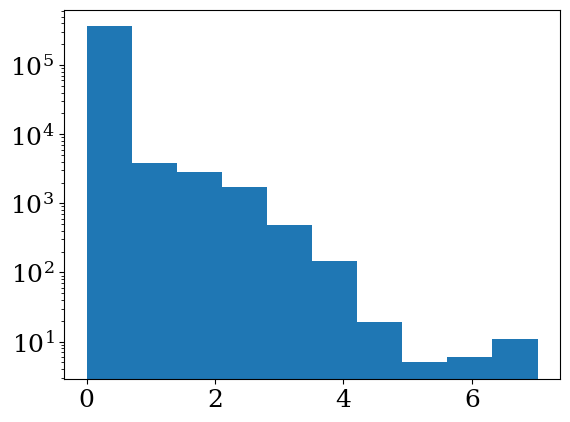

In [40]:
plt.hist(GAMA_mstar_concat[GAMA_mstar_concat['snratio'] > 25]['Z'])
plt.yscale('log')

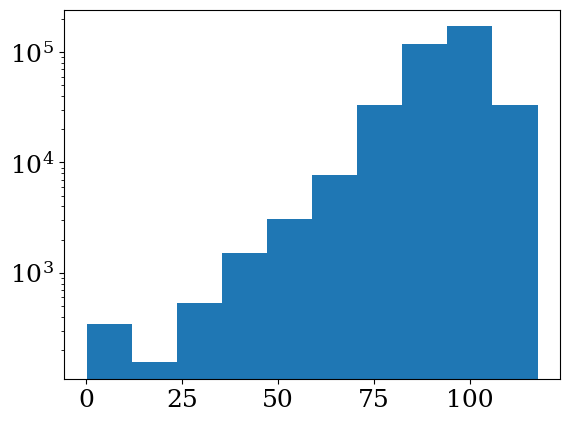

In [39]:
plt.hist(GAMA_mstar_concat['snratio'])
plt.yscale('log')

In [163]:
GAMA_idx = (GAMA_mstar_concat['snratio'] > 25) &\
           (12 < GAMA_mag_r.value) & (GAMA_mag_r.value < 28)&\
           (-1 < (GAMA_mstar_concat['absmag_g'] - GAMA_mstar_concat['absmag_r'])) &\
                ((GAMA_mstar_concat['absmag_g'] - GAMA_mstar_concat['absmag_r']) < 4) &\
           (GAMA_mstar_concat['logmstar'] > 3)

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_2552396/3207199602.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$r_{\mathrm{AB}}$')
/var/tmp/lsajkov/ipykernel_2552396/3207199602.py:14: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$(g-r)_{\mathrm{AB}}$')
/var/tmp/lsajkov/ipykernel_2552396/3207199602.py:20: SyntaxWarning: invalid escape sequence '\o'
  label = 'log$(M_*/M_{\odot})$')


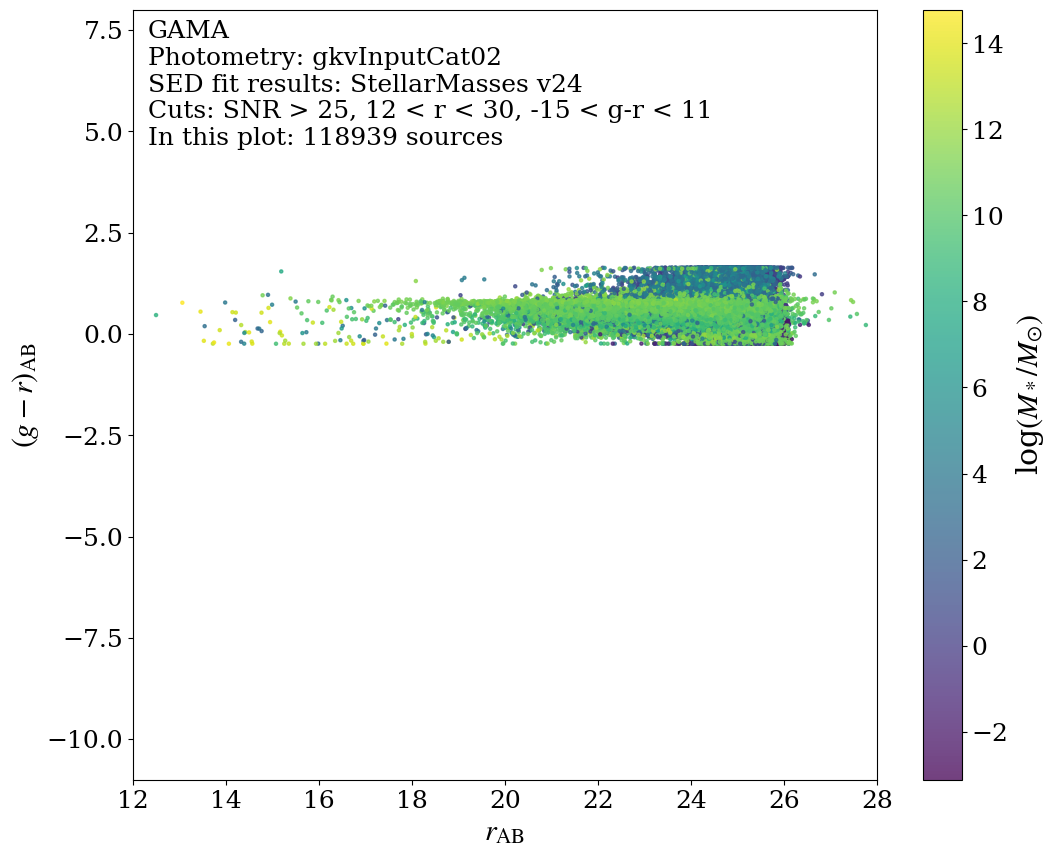

In [103]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()


 
mstar_scat = ax.scatter(GAMA_mag_r[GAMA_idx],
                        GAMA_mstar_concat[GAMA_idx]['absmag_g'] - GAMA_mstar_concat[GAMA_idx]['absmag_r'], 
           c = GAMA_mstar_concat[GAMA_idx]['logmstar'], alpha = 0.75,
           s = 5)
ax.set_xlim(12, 28)
ax.set_ylim(-11, 8)

ax.set_xlabel('$r_{\mathrm{AB}}$')
ax.set_ylabel('$(g-r)_{\mathrm{AB}}$')

ax.text(0.02, 0.825, f'GAMA\nPhotometry: gkvInputCat02\nSED fit results: StellarMasses v24\nCuts: SNR > 25, 12 < r < 30, -15 < g-r < 11\nIn this plot: {np.sum(idx)} sources',
        transform = ax.transAxes)

fig.colorbar(mstar_scat,
             label = 'log$(M_*/M_{\odot})$')

# fig.savefig('/data2/lsajkov/mpdg/figures/overlap_gama_kids_saga/gama_gr_r_mstar.pdf', dpi = 50)

## Look at KiDS

In [4]:
KiDS_dir = '/data2/lsajkov/mpdg/data/KiDS_spectroscopy'
KiDS_multiband_cats = fnmatch.filter(os.listdir(KiDS_dir), 'KiDS_DR4.1_*ugriZYJHKs_cat.fits')

In [68]:
KiDS_get_cols = ['ID', 'RAJ2000', 'DECJ2000',
                 'FWHM_WORLD', 'FLUX_RADIUS',
                 'MAG_GAAP_r', 'MAGERR_GAAP_r', 'FLAG_GAAP_r',
                 'MAG_GAAP_g', 'MAGERR_GAAP_g', 'FLAG_GAAP_g',
                 'COLOUR_GAAP_g_r']

with fits.open(f'{KiDS_dir}/{KiDS_multiband_cats[0]}') as cat:
    KiDS_table = Table(cat[1].data)
    KiDS_table = KiDS_table[KiDS_get_cols]

KiDS_sliced_cat = Table(dtype = KiDS_table.dtype)

In [69]:
for i, file in enumerate(KiDS_multiband_cats):
    if i % 40 == 0:
        with fits.open(f'{KiDS_dir}/{file}') as cat:
            KiDS_table = Table(cat[1].data)
            KiDS_table = KiDS_table[KiDS_get_cols]
        KiDS_sliced_cat = vstack([KiDS_sliced_cat, KiDS_table])

In [123]:
KiDS_idx = (mag_snr(KiDS_sliced_cat['MAGERR_GAAP_r']) > 25) &\
      (12 < KiDS_sliced_cat['MAG_GAAP_g']) & (KiDS_sliced_cat['MAG_GAAP_g'] < 28) &\
      (-1 < KiDS_sliced_cat['COLOUR_GAAP_g_r']) & (KiDS_sliced_cat['COLOUR_GAAP_g_r'] < 4)

In [160]:
np.sum(KiDS_idx)

118907

<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_2552396/61863449.py:26: SyntaxWarning: invalid escape sequence '\o'
  label = 'GAMA: log$(M_*/M_{\odot})$')


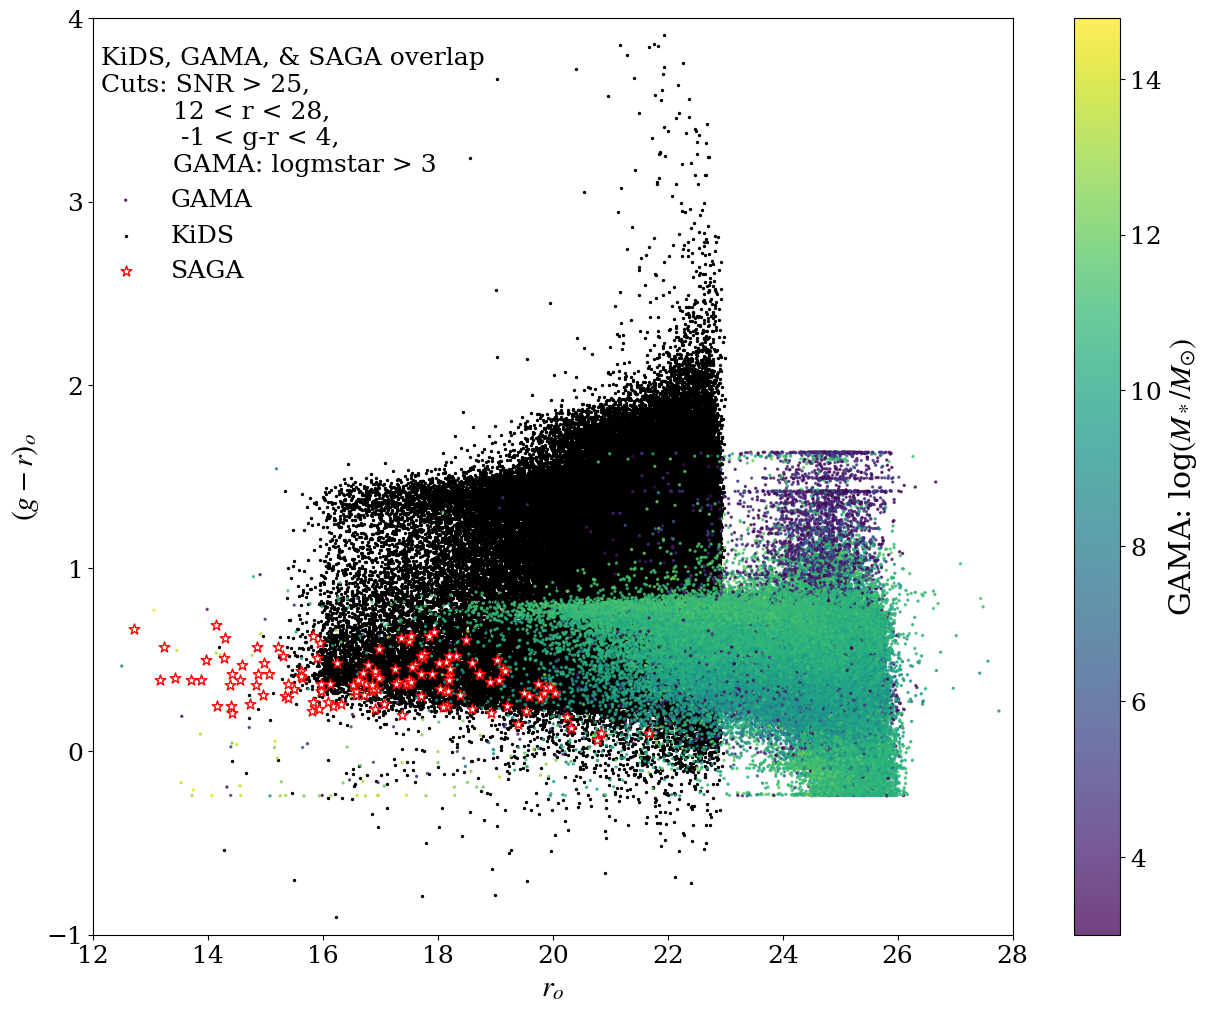

In [171]:
fig = plt.figure(figsize = (12, 10), constrained_layout = True)
ax = fig.add_subplot()

gama_mstar = ax.scatter(GAMA_mag_r[GAMA_idx],
                        GAMA_mstar_concat[GAMA_idx]['absmag_g'] - GAMA_mstar_concat[GAMA_idx]['absmag_r'], 
                        c = GAMA_mstar_concat[GAMA_idx]['logmstar'], cmap = 'viridis', alpha = 0.75,
                        s = 2, label = 'GAMA')
 
ax.scatter(KiDS_sliced_cat[KiDS_idx]['MAG_GAAP_r'],
           KiDS_sliced_cat[KiDS_idx]['COLOUR_GAAP_g_r'],
           c = 'black', s = 2, label = 'KiDS', zorder = 0)

ax.scatter(satsData['R'], satsData['GR'],  label = 'SAGA', zorder = 9, s = 64, marker = '*', facecolor = 'white',  edgecolor = 'red')

ax.set_xlim(12, 28)
ax.set_ylim(-1, 4)

ax.set_xlabel('$r_o$')
ax.set_ylabel('$(g-r)_o$')

fig.legend(title = f'KiDS, GAMA, & SAGA overlap\nCuts: SNR > 25,\n         12 < r < 28,\n          -1 < g-r < 4,\n         GAMA: logmstar > 3',
           frameon = False,
           loc = (0.075, 0.71),
           alignment = 'left')
fig.colorbar(gama_mstar,
             label = 'GAMA: log$(M_*/M_{\odot})$')

fig.savefig('/data2/lsajkov/mpdg/figures/overlap_gama_kids_saga/overlap_gama_kids_saga.png', dpi = 50, bbox_inches = 'tight')

<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
/var/tmp/lsajkov/ipykernel_2552396/3922843868.py:27: SyntaxWarning: invalid escape sequence '\o'
  label = 'log$(M_*/M_{\odot})$')


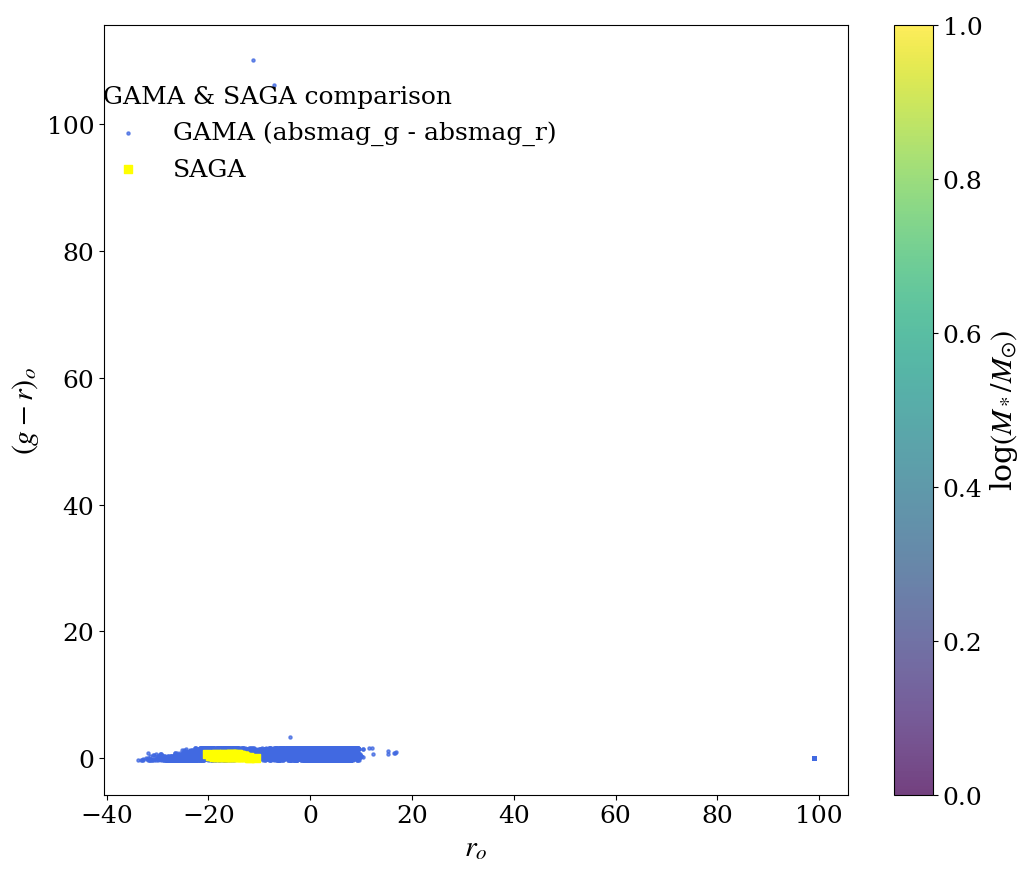

In [136]:
fig = plt.figure(figsize = (12, 10), constrained_layout = True)
ax = fig.add_subplot()

gama_mstar = ax.scatter(GAMA_mstar_concat['absmag_r'],
                        GAMA_mstar_concat['absmag_g'] - GAMA_mstar_concat['absmag_r'], 
                        c = 'royalblue', alpha = 0.75,
                        s = 5, label = 'GAMA (absmag_g - absmag_r)')
 
# ax.scatter(KiDS_sliced_cat[KiDS_idx]['MAG_GAAP_r'],
#            KiDS_sliced_cat[KiDS_idx]['COLOUR_GAAP_g_r'],
#            c = 'black', s = 5, label = 'KiDS', zorder = 0)

ax.scatter(satsData['R_ABS'], satsData['GR'],  label = 'SAGA', zorder = 9, color = 'yellow', marker = 's')


# ax.set_xlim(12, 28)
# ax.set_ylim(-1, 4)

ax.set_xlabel('$r_o$')
ax.set_ylabel('$(g-r)_o$')

fig.legend(title = f'GAMA & SAGA comparison',
           frameon = False,
           loc = (0.09, 0.78),
           alignment = 'left')
fig.colorbar(gama_mstar,
             label = 'log$(M_*/M_{\odot})$')

# fig.savefig('/data2/lsajkov/mpdg/figures/overlap_gama_kids_saga/overlap_gama_kids.pdf', dpi = 50)

In [137]:
satsData['R']

17.06
17.26
18.13
18.93
16.91
20.24
14.83
17.5
17.74
15.97
16.57


In [130]:
satsData['GR']

0.26
0.45
0.33
0.21
0.42
0.19
0.36
0.37
0.51
0.33
0.31
